# Matching detections with SN Truth Catalog

## Summary
* Loading the data
* Defining convenient functions to unfold LightCurves
* Initialize tables and matching distance tolerance
* Producing the actual matching
* Producing the plots

In [1]:
import os
import sqlite3

In [2]:
os.environ['SCRATCH']='/global/cscratch1/sd/bos0109'
SCRATCH = %env SCRATCH

In [3]:
import numpy as np

In [4]:
import matplotlib.pyplot as plt
import pandas as pd

In [5]:
%matplotlib inline

In [6]:
from glob import glob

In [7]:
from astropy import time
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import vstack

### Loading the data
 We are loading the data from a set of files already produced and stored.
 The files contain the truth catalog for SN Ia and their parameters, as well
 a HDF5 storage container with the `diaSrc` catalogs stacked as a single table.

In [8]:
truth_lightc = pd.read_csv('../lightcurves/lightcurves_cat_rect_58.0_56.0_-31.0_-32.0.csv')
sntab = pd.read_csv('../catalogs+tables/supernovae_cat_rect_58.0_56.0_-31.0_-32.0.csv')
#truth_lightc = pd.read_csv('./lightcurves/lightcurves_cat_rect_58_56_-31_-32.csv')
#sntab = pd.read_csv('./catalogs+tables/supernovae_cat_rect_58_56_-31_-32.csv')

In [9]:
#diaSrc_store = pd.HDFStore('/global/cscratch1/sd/bos0109/diaSrc_forced_fulltables_v4.h5')
diaSrc_store = pd.HDFStore(f'{SCRATCH}/results/diaSrc_secrun_fulltables_v4.h5')
diaSrc_store.open()
metacols = ['id', 'visit', 'filter', 'raftName', 'detectorName', 'detector']

### Defining convenient functions 

* Dealing with the truth catalog table and the SN parameters table is best achieved if encapsulated as single functions

In [10]:
def get_truth_LC(truth_tab, snid):
    sffx = ('_observable', '_observed', '_flux', '_fluxErr', '_mag', '_magErr')
    snid = str(snid)
    colset = ['mjd', 'filter', 'visitn'] + [snid+acol for acol in sffx]
    tab = truth_tab[colset].copy()
    transl = {snid+acol: acol[1:] for acol in sffx}
    tab.rename(columns=transl, inplace=True)
    tab['snid_in'] = snid
    return tab[tab.observable]

* Unfold the lightcurves from the table using the above function

In [11]:
snids = [acol.strip('_observed') for acol in truth_lightc.columns 
        if '_observed' in acol]
lcs = []
for asnid in snids:
    lcs.append(get_truth_LC(truth_lightc, asnid))
lcs = pd.concat(lcs)

### Defining the tolerance and table lists

In [12]:
diasrc_tab = diaSrc_store['full_table']

d_tol = 2.5*u.arcsec
lc_list = []
visits_used = []
diasrc_list = []
N_matches = 0

In [13]:
diaSrc_store.close()

### Matching 
* Using the visit number as the grouping column in the `diaSrc` table 
* Comparing sky positions with the SN and `diaSrc` instances

In [14]:
lcs['visit_used'] = False

In [15]:
for avisit, atab in diasrc_tab.groupby('visit_n'):
    # light curve row:
    lc = lcs.loc[lcs['visitn']==avisit].copy()
    snlist = sntab[sntab.snid_in.isin(lc.snid_in)]
    
    if lc.empty or snlist.empty:
        continue
    
    lcs.loc[lcs['visitn']==avisit, 'visit_used'] = True
    visits_used.append(avisit)
    #print(avisit)
    sncoords = SkyCoord(ra=snlist.snra_in*u.deg, dec=snlist.sndec_in*u.deg)

    #srctab = atab[~atab.base_PixelFlags_flag_saturated].copy()
    #srctab = srctab[~srctab.base_PixelFlags_flag_edge].copy()
    #srctab = srctab[~srctab.ip_diffim_DipoleFit_flag_classification].copy()
    srctab = atab.copy()
    diacoords = SkyCoord(ra=srctab.coord_ra*u.rad, dec=srctab.coord_dec*u.rad)
    
    idx, d2d, d3d = sncoords.match_to_catalog_sky(diacoords)
    idx_, d2d_, d3d_ = diacoords.match_to_catalog_sky(sncoords)

    match = np.repeat(False, len(idx))
    matchO = np.repeat(False, len(idx_))
    not_matched = []
    for i in range(len(idx)):
        if i==idx_[idx[i]] and d2d[i]<d_tol and d2d_[idx[i]]<d_tol:
            match[i] = True
            matchO[idx[i]] = True
        else:
            not_matched.append([i, idx[i], idx_[idx[i]]])
    not_matched = np.array(not_matched)
    lc['matched'] = match
    lc['match_ang_dist'] = d2d.to(u.arcsec)
    lc['dia_row'] = idx
    lc['dia_id'] = srctab.iloc[idx]['id'].values

    srctab['cxmatch'] = matchO
    srctab['sn_row'] = idx_
    srctab['match_ang_dist'] = d2d_.to(u.arcsec)
    srctab['sn_id'] = lc.iloc[idx_]['snid_in'].values

    N_matches += np.sum(match)

    lc_list.append(lc)
    diasrc_list.append(srctab)
print(N_matches)

1432


In [16]:
matched_lcs = pd.concat(lc_list)
matched_diasrc = pd.concat(diasrc_list)

In [17]:
len(matched_lcs)

10971

In [18]:
np.sum(matched_lcs['matched'])

1432

In [19]:
len(matched_diasrc)

636408

### Producing interesting plots 
* Checking the matching fraction of the `diaSrc` to truth SN lightcurves
* Checking different parameters as proxy to the matching fraction
    * Magnitude
    * Signal to Noise
    * MJDs
    * Flux errors
* Analyzing the matching stats 
    * angular distance
    * Matches per filter bandpass

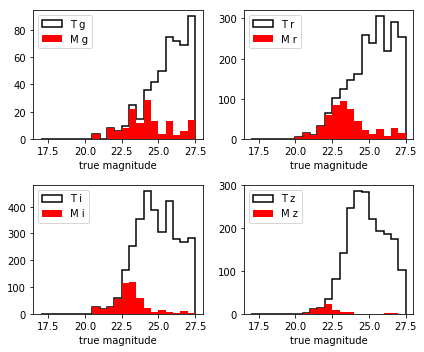

In [20]:
bandpasses = ('g', 'r', 'i', 'z')
bins=np.arange(17, 28, 0.5)
fig, axes = plt.subplots(figsize=(6,5), nrows=2, ncols=2)

for ax, band in zip(axes.flatten(), bandpasses):
    subtab = matched_lcs.loc[matched_lcs['filter']==band]

    ax.hist(subtab.mag, histtype='step', lw=1.5, color='k', bins=bins, 
            label=f'T {band}')

    ax.hist(subtab[subtab.matched].mag, histtype='stepfilled', lw=1.5, 
            bins=bins, color='red', label=f'M {band}')
    ax.set_xlabel('true magnitude')
    ax.legend(loc='upper left')
plt.tight_layout()

#plt.savefig('matched_lcs.png')
#plt.clf()

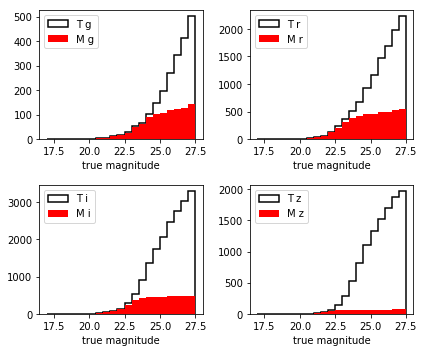

In [21]:
bandpasses = ('g', 'r', 'i', 'z')
bins=np.arange(17, 28, 0.5)
fig, axes = plt.subplots(figsize=(6,5), nrows=2, ncols=2)

for ax, band in zip(axes.flatten(), bandpasses):
    subtab = matched_lcs.loc[matched_lcs['filter']==band]

    ax.hist(subtab.mag, histtype='step', lw=1.5, color='k', bins=bins, 
            label=f'T {band}', cumulative=True)

    ax.hist(subtab[subtab.matched].mag, histtype='stepfilled', lw=1.5, 
            bins=bins, color='red', label=f'M {band}', cumulative=True)
    ax.legend(loc='upper left')
    ax.set_xlabel('true magnitude')
plt.tight_layout()
#plt.savefig('matched_lcs.png')
#plt.clf()

In [22]:
matched_diasrc.columns

Index(['id', 'coord_ra', 'coord_dec', 'parent', 'flags_negative',
       'base_NaiveCentroid_x', 'base_NaiveCentroid_y',
       'base_NaiveCentroid_flag', 'base_NaiveCentroid_flag_noCounts',
       'base_NaiveCentroid_flag_edge',
       ...
       'slot_Shape_psf_moments_ratio_qs', 'slot_Shape_psf_moments_quad',
       'slot_Shape_psf_moments_diag_xx', 'slot_Shape_psf_moments_diag_yy',
       'slot_Shape_psf_moments_diag_ratio', 'slot_Shape_psf_moments_diag_quad',
       'cxmatch', 'sn_row', 'match_ang_dist', 'sn_id'],
      dtype='object', length=311)

In [23]:
reals = matched_diasrc.loc[matched_diasrc['cxmatch']]

In [24]:
SNcols = [acol for acol in reals.columns if '_SN' in acol]

In [25]:
SNcols

['base_SdssShape_instFlux_SN',
 'slot_Shape_instFlux_SN',
 'base_CircularApertureFlux_3_0_instFlux_SN',
 'base_CircularApertureFlux_4_5_instFlux_SN',
 'base_CircularApertureFlux_6_0_instFlux_SN',
 'base_CircularApertureFlux_9_0_instFlux_SN',
 'base_CircularApertureFlux_12_0_instFlux_SN',
 'slot_ApFlux_instFlux_SN',
 'base_CircularApertureFlux_17_0_instFlux_SN',
 'base_CircularApertureFlux_25_0_instFlux_SN',
 'base_CircularApertureFlux_35_0_instFlux_SN',
 'base_CircularApertureFlux_50_0_instFlux_SN',
 'base_CircularApertureFlux_70_0_instFlux_SN',
 'base_GaussianFlux_instFlux_SN',
 'base_PeakLikelihoodFlux_instFlux_SN',
 'base_PsfFlux_instFlux_SN',
 'slot_PsfFlux_instFlux_SN',
 'ip_diffim_NaiveDipoleFlux_pos_instFlux_SN',
 'ip_diffim_NaiveDipoleFlux_neg_instFlux_SN',
 'ip_diffim_PsfDipoleFlux_pos_instFlux_SN',
 'ip_diffim_PsfDipoleFlux_neg_instFlux_SN',
 'ip_diffim_DipoleFit_pos_instFlux_SN',
 'ip_diffim_DipoleFit_neg_instFlux_SN',
 'ip_diffim_forced_PsfFlux_instFlux_SN']

/global/common/software/lsst/common/miniconda/py3-4.5.12/envs/stack/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/global/common/software/lsst/common/miniconda/py3-4.5.12/envs/stack/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


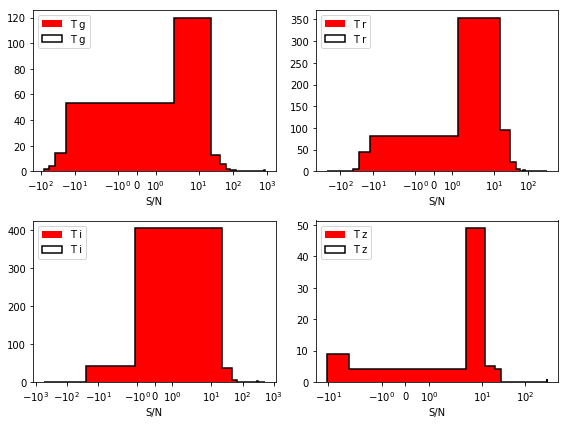

In [26]:
bandpasses = ('g', 'r', 'i', 'z')
#bins=np.arange(17, 28, 0.5)
fig, axes = plt.subplots(figsize=(8,6), nrows=2, ncols=2)

for ax, band in zip(axes.flatten(), bandpasses):
    subtab = reals.loc[reals['filter']==band]

    ax.hist(subtab.base_PsfFlux_instFlux_SN, histtype='stepfilled', lw=1.5, color='red', bins=45, 
            label=f'T {band}', cumulative=False, log=False)
    ax.hist(subtab.base_PsfFlux_instFlux_SN, histtype='step', lw=1.5, color='k', bins=45, 
            label=f'T {band}', cumulative=False, log=False)
    ax.set_xscale('symlog')
    #ax.hist(subtab[subtab.matched].base_PsfFlux_instFlux_SN, histtype='stepfilled', lw=1.5, 
    #        bins=bins, color='red', label=f'M {band}', cumulative=True)
    ax.legend(loc='upper left')
    ax.set_xlabel('S/N')
plt.tight_layout()
#plt.savefig('matched_lcs.png')
#plt.clf()

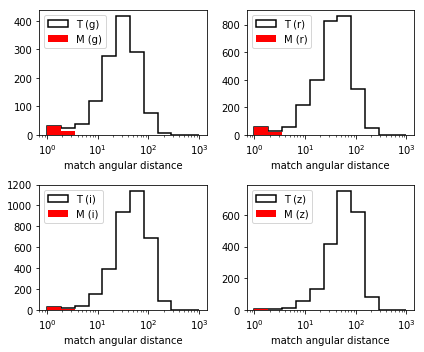

In [27]:
bandpasses = ('g', 'r', 'i', 'z')
bins = np.logspace(0, 3, num=12)
fig, axes = plt.subplots(figsize=(6,5), nrows=2, ncols=2)

for ax, band in zip(axes.flatten(), bandpasses):
    subtab = matched_lcs.loc[matched_lcs['filter']==band]

    ax.hist(subtab.match_ang_dist, histtype='step', lw=1.5, color='k', bins=bins, 
            label=f'T ({band})')

    ax.hist(subtab[subtab.matched].match_ang_dist, histtype='stepfilled', lw=1.5, 
            bins=bins, color='red', label=f'M ({band})')
    ax.legend(loc='upper left')
    ax.set_xscale('log')
    ax.set_xlabel('match angular distance')
plt.tight_layout()

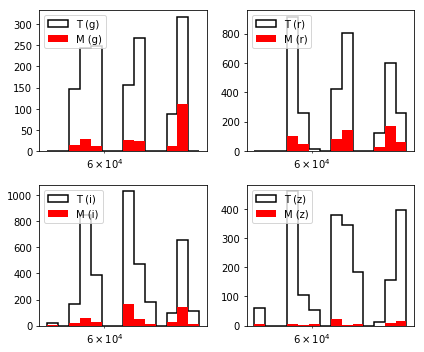

In [28]:
bandpasses = ('g', 'r', 'i', 'z')
bins = np.linspace(59580, 60700, num=15)
fig, axes = plt.subplots(figsize=(6,5), nrows=2, ncols=2)

for ax, band in zip(axes.flatten(), bandpasses):
    subtab = matched_lcs.loc[matched_lcs['filter']==band]

    ax.hist(subtab.mjd, histtype='step', lw=1.5, color='k', bins=bins, 
            label=f'T ({band})')

    ax.hist(subtab[subtab.matched].mjd, histtype='stepfilled', lw=1.5, 
            bins=bins, color='red', label=f'M ({band})')
    ax.legend(loc='upper left')
    ax.set_xscale('log')
plt.tight_layout()

In [29]:
matched_lcs.columns

Index(['mjd', 'filter', 'visitn', 'observable', 'observed', 'flux', 'fluxErr',
       'mag', 'magErr', 'snid_in', 'visit_used', 'matched', 'match_ang_dist',
       'dia_row', 'dia_id'],
      dtype='object')

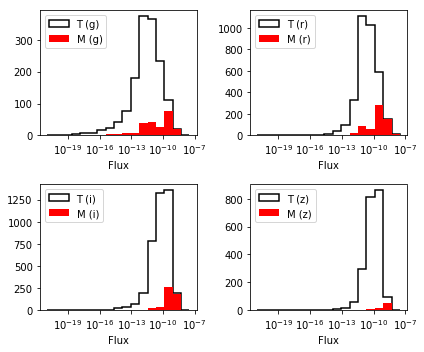

In [30]:
bandpasses = ('g', 'r', 'i', 'z')
bins = np.logspace(-21, -7.5, num=18)
fig, axes = plt.subplots(figsize=(6,5), nrows=2, ncols=2)

for ax, band in zip(axes.flatten(), bandpasses):
    subtab = matched_lcs.loc[matched_lcs['filter']==band]

    ax.hist(subtab.flux, histtype='step', lw=1.5, color='k', bins=bins, 
            label=f'T ({band})')

    ax.hist(subtab[subtab.matched].flux, histtype='stepfilled', lw=1.5, 
            bins=bins, color='red', label=f'M ({band})')
    ax.legend(loc='upper left')
    ax.set_xlabel('Flux')
    ax.set_xscale('log')
plt.tight_layout()

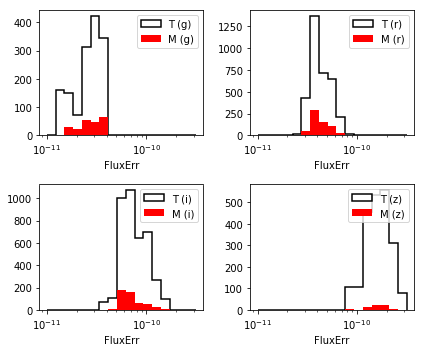

In [31]:
bandpasses = ('g', 'r', 'i', 'z')
bins = np.logspace(-11, -9.5, num=18)
fig, axes = plt.subplots(figsize=(6,5), nrows=2, ncols=2)

for ax, band in zip(axes.flatten(), bandpasses):
    subtab = matched_lcs.loc[matched_lcs['filter']==band]

    ax.hist(subtab.fluxErr, histtype='step', lw=1.5, color='k', bins=bins, 
            label=f'T ({band})')

    ax.hist(subtab[subtab.matched].fluxErr, histtype='stepfilled', lw=1.5, 
            bins=bins, color='red', label=f'M ({band})')
    ax.legend(loc='best')
    ax.set_xlabel('FluxErr')
    ax.set_xscale('log')
plt.tight_layout()

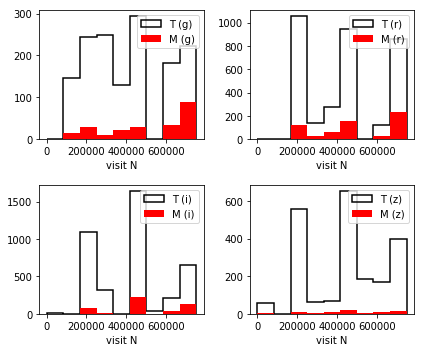

In [32]:
bandpasses = ('g', 'r', 'i', 'z')
bins = np.linspace(1500, 750000, num=10)
fig, axes = plt.subplots(figsize=(6,5), nrows=2, ncols=2)

for ax, band in zip(axes.flatten(), bandpasses):
    subtab = matched_lcs.loc[matched_lcs['filter']==band]

    ax.hist(subtab.visitn, histtype='step', lw=1.5, color='k', bins=bins, 
            label=f'T ({band})')

    ax.hist(subtab[subtab.matched].visitn, histtype='stepfilled', lw=1.5, 
            bins=bins, color='red', label=f'M ({band})')
    ax.legend(loc='best')
    ax.set_xlabel('visit N')
    ax.set_xscale('linear')
plt.tight_layout()

In [33]:
matched_lcs.describe()

,mjd,visitn,flux,fluxErr,mag,magErr,match_ang_dist,dia_row,dia_id
count,10971.000000,10971.000000,1.097100e+04,1.097100e+04,10971.000000,10971.000000,10971.000000,10971.000000,1.097100e+04
mean,60194.367468,425989.469511,1.850996e-10,7.890560e-11,26.297250,1.667140,47.452533,1271.720992,2.858768e+16
std,284.902091,185803.977292,4.793894e-10,5.473531e-11,2.780347,1.989267,40.210840,1245.735706,1.246909e+16
min,59589.200927,6826.000000,6.638158e-21,1.434397e-11,19.855938,0.007867,0.001487,0.000000,4.580965e+14
25%,59887.187640,227918.000000,8.764920e-12,3.744822e-11,24.375799,0.391296,18.050716,405.000000,1.529533e+16
50%,60201.256555,433989.000000,4.414218e-11,5.918186e-11,25.887866,1.030063,39.625730,884.000000,2.912452e+16
75%,60530.342606,637849.000000,1.776972e-10,1.005742e-10,27.643130,2.278055,68.002891,1693.000000,4.280533e+16
max,60661.175194,731791.000000,1.141892e-08,2.775778e-10,50.444881,24.221286,338.390830,9731.000000,4.910966e+16


In [34]:
rows = []
for ivisit, subset in matched_lcs.groupby('visitn'):
    #print(str(ivisit).zfill(6), np.sum(subset.matched), str(len(subset)).zfill(2), f'{np.sum(subset.matched)/len(subset):.3}')
    rows.append([ivisit, np.sum(subset.matched), len(subset), np.sum(subset.matched)/len(subset), subset['filter'].values[0]])
summ = pd.DataFrame(data=rows, columns=['visitn', 'n_matches', 'total', 'fraction', 'bandpass'])

In [35]:
len(summ)

331

In [36]:
for band, subtab in summ.groupby('bandpass'):
    print(f'Bandpass {band} \n', subtab.describe(), '\n\n')

Bandpass g 
              visitn  n_matches      total   fraction
count      43.00000  43.000000  43.000000  43.000000
mean   408819.44186   5.232558  34.093023   0.140606
std    201107.07931   5.340043  19.575025   0.127322
min    159479.00000   0.000000   1.000000   0.000000
25%    193825.00000   1.500000  20.000000   0.053660
50%    400390.00000   4.000000  34.000000   0.115385
75%    635788.50000   7.000000  48.000000   0.188345
max    697990.00000  19.000000  69.000000   0.447368 


Bandpass i 
               visitn   n_matches       total    fraction
count     108.000000  108.000000  108.000000  108.000000
mean   440555.046296    4.675926   36.712963    0.134834
std    192843.116402    4.423448   23.292954    0.131006
min      6826.000000    0.000000    1.000000    0.000000
25%    239998.250000    2.000000   16.750000    0.063497
50%    435658.500000    3.000000   35.000000    0.096332
75%    654465.250000    7.000000   55.000000    0.169727
max    731791.000000   20.000000   84.

------

In [37]:
matched_diasrc.columns

Index(['id', 'coord_ra', 'coord_dec', 'parent', 'flags_negative',
       'base_NaiveCentroid_x', 'base_NaiveCentroid_y',
       'base_NaiveCentroid_flag', 'base_NaiveCentroid_flag_noCounts',
       'base_NaiveCentroid_flag_edge',
       ...
       'slot_Shape_psf_moments_ratio_qs', 'slot_Shape_psf_moments_quad',
       'slot_Shape_psf_moments_diag_xx', 'slot_Shape_psf_moments_diag_yy',
       'slot_Shape_psf_moments_diag_ratio', 'slot_Shape_psf_moments_diag_quad',
       'cxmatch', 'sn_row', 'match_ang_dist', 'sn_id'],
      dtype='object', length=311)

In [38]:
matched_diasrc.describe()

,id,coord_ra,coord_dec,parent,base_NaiveCentroid_x,base_NaiveCentroid_y,base_PeakCentroid_x,base_PeakCentroid_y,base_SdssCentroid_x,base_SdssCentroid_y,...,slot_PsfShape_moments_diag_ratio,slot_PsfShape_moments_diag_quad,slot_Shape_psf_moments_ratio_qs,slot_Shape_psf_moments_quad,slot_Shape_psf_moments_diag_xx,slot_Shape_psf_moments_diag_yy,slot_Shape_psf_moments_diag_ratio,slot_Shape_psf_moments_diag_quad,sn_row,match_ang_dist
count,6.364080e+05,636408.000000,636408.000000,636408.0,636408.000000,636408.000000,636408.000000,636408.000000,636408.000000,636408.000000,...,636407.000000,636407.000000,636407.000000,636407.000000,636407.000000,636407.000000,636407.000000,636407.000000,636408.000000,636408.000000
mean,3.261327e+16,0.993370,-0.549664,0.0,2037.343905,1984.234818,2037.708787,1984.524520,2037.664048,1984.371608,...,1.064917,123.577704,0.986902,30.875175,7.536123,7.098830,1.064917,123.577704,22.203965,411.149886
std,1.257564e+16,0.011213,0.006187,0.0,1168.559480,1148.065988,1168.537137,1148.061364,1168.410183,1148.073253,...,0.082933,105.793711,0.066412,26.442259,2.931956,2.791923,0.082933,105.793711,16.772552,285.401477
min,4.580950e+14,0.973496,-0.560234,0.0,10.197740,-88.828377,14.000000,14.000000,8.179040,-88.828377,...,1.000119,20.162035,0.545226,5.039769,3.211911,1.364317,1.000119,20.162035,0.000000,0.001487
25%,2.686751e+16,0.983799,-0.554871,0.0,1028.879630,990.775023,1029.000000,991.000000,1029.178881,990.903931,...,1.022428,53.220617,0.973608,13.260716,5.367239,4.819740,1.022428,53.220617,8.000000,212.883276
50%,3.115101e+16,0.993067,-0.549764,0.0,2039.188865,1974.237061,2040.000000,1975.000000,2039.613106,1974.583742,...,1.039096,93.443679,0.997107,23.348531,6.986657,6.648051,1.039096,93.443679,19.000000,349.775478
75%,4.541908e+16,1.002745,-0.544489,0.0,3046.045653,2975.269302,3046.000000,2976.000000,3046.061076,2975.675864,...,1.065424,137.253979,1.019773,34.231849,8.600358,8.017268,1.065424,137.253979,34.000000,539.452034
max,4.910967e+16,1.014813,-0.537942,0.0,4060.368754,4032.468262,4057.000000,3985.000000,4067.090576,4032.468262,...,10.061156,874.010915,1.344573,218.104779,21.799305,19.996379,10.061156,874.010915,83.000000,3539.139321


-----
### Storing datasets

* Storing the datasets as three tables:
    * Reals table (`diaSrc` instances that have been matched to a SN lightcurve epoch)
    * Bogus table (`diaSrc` instances that have **NOT** been matched to a SN lightcurve epoch)
    * Matched LCs table (truth lightcurve table with the matching result information attached.)

In [39]:
reals = matched_diasrc.loc[matched_diasrc['cxmatch']]
bogus = matched_diasrc.loc[~matched_diasrc['cxmatch']]

In [40]:
len(reals)

1432

In [41]:
len(bogus)

634976

The following quantity reflects the actual portion of the truth lightcurve instances that were possible to be used because of image processing failing

In [42]:
np.sum(lcs['visit_used'])/len(lcs)

0.4040288723576637

In [43]:
len(matched_lcs)/len(lcs)

0.4040288723576637

In [44]:
(len(reals) + len(bogus))/len(diasrc_tab)

0.9848879479643996

In [45]:
reals.to_csv(f'{SCRATCH}/results/reals_table.csv')
bogus.to_csv(f'{SCRATCH}/results/bogus_table.csv')
matched_lcs.to_csv(f'{SCRATCH}/results/matched_lcs_visit_by_visit.csv')

----------
## Analyzing combined detection samples

In [46]:
[acol for acol in reals.columns if 'instFlux_SN' in acol]

['base_SdssShape_instFlux_SN',
 'slot_Shape_instFlux_SN',
 'base_CircularApertureFlux_3_0_instFlux_SN',
 'base_CircularApertureFlux_4_5_instFlux_SN',
 'base_CircularApertureFlux_6_0_instFlux_SN',
 'base_CircularApertureFlux_9_0_instFlux_SN',
 'base_CircularApertureFlux_12_0_instFlux_SN',
 'slot_ApFlux_instFlux_SN',
 'base_CircularApertureFlux_17_0_instFlux_SN',
 'base_CircularApertureFlux_25_0_instFlux_SN',
 'base_CircularApertureFlux_35_0_instFlux_SN',
 'base_CircularApertureFlux_50_0_instFlux_SN',
 'base_CircularApertureFlux_70_0_instFlux_SN',
 'base_GaussianFlux_instFlux_SN',
 'base_PeakLikelihoodFlux_instFlux_SN',
 'base_PsfFlux_instFlux_SN',
 'slot_PsfFlux_instFlux_SN',
 'ip_diffim_NaiveDipoleFlux_pos_instFlux_SN',
 'ip_diffim_NaiveDipoleFlux_neg_instFlux_SN',
 'ip_diffim_PsfDipoleFlux_pos_instFlux_SN',
 'ip_diffim_PsfDipoleFlux_neg_instFlux_SN',
 'ip_diffim_DipoleFit_pos_instFlux_SN',
 'ip_diffim_DipoleFit_neg_instFlux_SN',
 'ip_diffim_forced_PsfFlux_instFlux_SN']

([array([1.000e+00, 0.000e+00, 1.000e+00, 1.322e+03, 7.500e+01, 0.000e+00,
         8.000e+00, 1.000e+00, 0.000e+00, 1.000e+00]),
  array([0.000e+00, 0.000e+00, 0.000e+00, 1.063e+03, 7.700e+01, 3.000e+00,
         5.000e+00, 1.000e+00, 0.000e+00, 1.000e+00])],
 array([-530.133131  , -390.12380896, -250.11448693, -110.1051649 ,
          29.90415713,  169.91347917,  309.9228012 ,  449.93212323,
         589.94144526,  729.9507673 ,  869.96008933]),
 <a list of 2 Lists of Patches objects>)

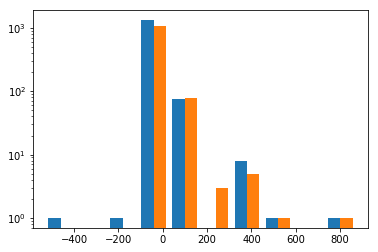

In [47]:
plt.hist(reals[['base_PsfFlux_instFlux_SN',
                'base_GaussianFlux_instFlux_SN']].values, log=True)

/global/common/software/lsst/common/miniconda/py3-4.5.12/envs/stack/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6575: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/global/common/software/lsst/common/miniconda/py3-4.5.12/envs/stack/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6576: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


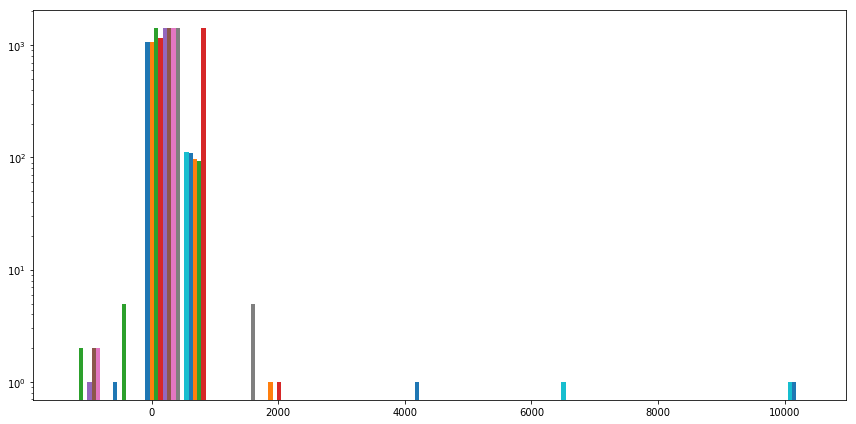

In [48]:
plt.figure(figsize=(12, 6))
plt.hist(reals[[acol for acol in reals.columns if 'instFlux_SN' in acol and 'Circular' not in acol]].values, log=True)
plt.tight_layout()

-----------

_Moved to the visit_check.ipynb Notebook_
### Analyzing visits used